In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from vachoppy.trajectory import LatticeHopping
from vachoppy.fingerprint import FingerPrint, CosineDistance

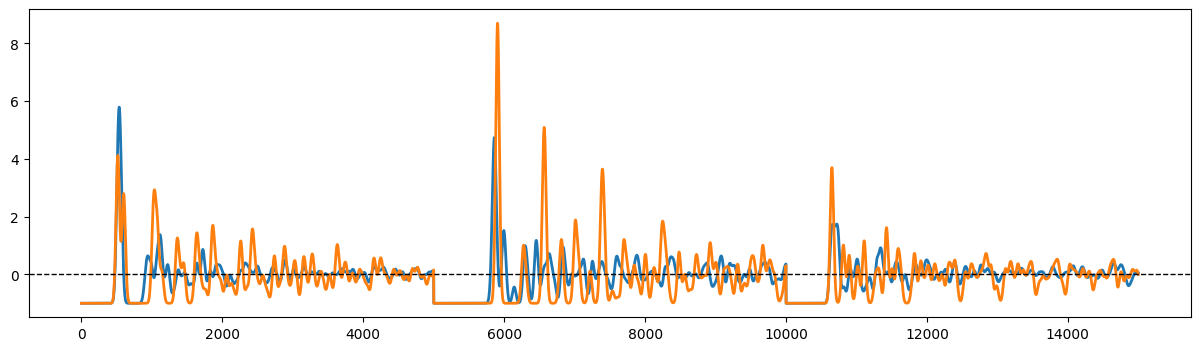

In [5]:
Rmax, delta, sigma = 20, 0.004, 0.1
# Rmax, delta, sigma = 15, 0.01, 0.1
# Rmax, delta, sigma = 10, 0.05, 0.1

# monoclinc
fp_m_hfo = FingerPrint(A='Hf', 
                       B='O', 
                       poscar='poscars_hfo2/POSCAR_mHfO2', 
                       Rmax=Rmax, 
                       delta=delta, 
                       sigma=sigma)
fp_m_hfhf = FingerPrint(A='Hf', 
                        B='Hf', 
                        poscar='poscars_hfo2/POSCAR_mHfO2', 
                        Rmax=Rmax, 
                        delta=delta, 
                        sigma=sigma)
fp_m_oo = FingerPrint(A='O', 
                      B='O', 
                      poscar='poscars_hfo2/POSCAR_mHfO2', 
                      Rmax=Rmax, 
                      delta=delta, 
                      sigma=sigma)

# Tetragonal
fp_t_hfo = FingerPrint(A='Hf', 
                       B='O', 
                       poscar='poscars_hfo2/POSCAR_tHfO2', 
                       Rmax=Rmax, 
                       delta=delta, 
                       sigma=sigma)
fp_t_hfhf = FingerPrint(A='Hf', 
                        B='Hf', 
                        poscar='poscars_hfo2/POSCAR_tHfO2', 
                        Rmax=Rmax, 
                        delta=delta, 
                        sigma=sigma)
fp_t_oo = FingerPrint(A='O', 
                      B='O', 
                      poscar='poscars_hfo2/POSCAR_tHfO2', 
                      Rmax=Rmax, 
                      delta=delta, 
                      sigma=sigma)

fp_m = np.concatenate((fp_m_hfo.fingerprint, 
                       fp_m_hfhf.fingerprint, 
                       fp_m_oo.fingerprint))
fp_t = np.concatenate((fp_t_hfo.fingerprint, 
                       fp_t_hfhf.fingerprint, 
                       fp_t_oo.fingerprint))


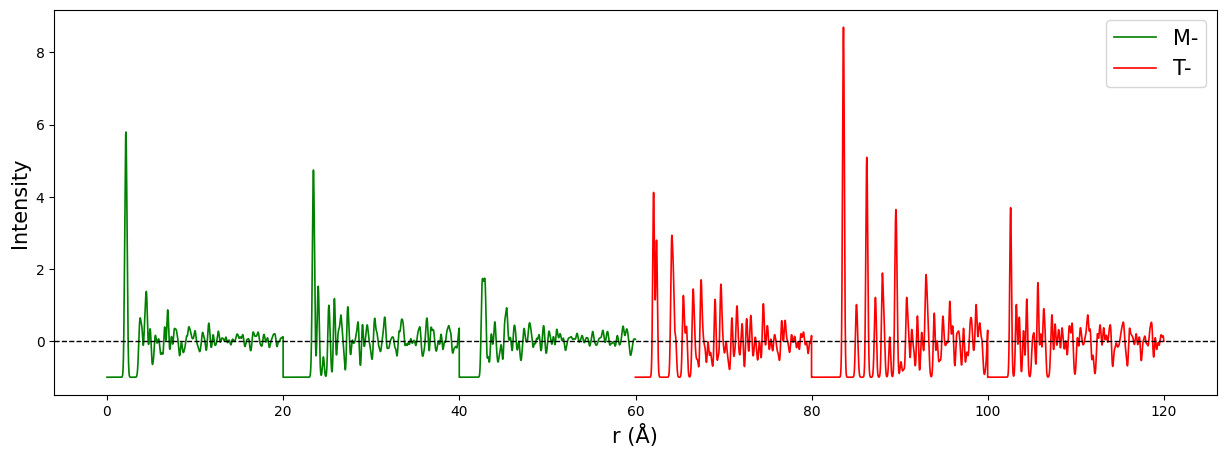

In [26]:

# plot fingerprints
x1 = fp_m_hfo.R
x2 = x1 + x1[-1]
x3 = x1 + x2[-1]
distance_m = np.concatenate((x1, x2, x3))
distance_t = distance_m+distance_m[-1]

plt.figure(figsize=(15, 5))
plt.plot(distance_m, fp_m, 'g-', linewidth=1.2, label='M-')
plt.plot(distance_t, fp_t, 'r-', linewidth=1.2, label='T-')
plt.axhline(0, 0, 1, color='k', linestyle='--', linewidth=1)

plt.xlabel("r (Å)", fontsize=15)
plt.ylabel('Intensity', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [96]:
def get_fingerprints(temp, 
                     ensemble):
    
    ensemble = format(ensemble,'02')

    # path of poscar and xdatcar
    poscar_perf = f'../xdatcar.hfo2.{temp}K/POSCAR_SUPERCELL'
    xdatcar = f'../xdatcar.hfo2.{temp}K/XDATCAR_{ensemble}'

    # extract trajectory from xdatcar
    traj = LatticeHopping(poscar_perf=poscar_perf,
                          xdatcar=xdatcar,
                          interval=50,
                          target='O')

    # generate POSCAR files
    step = np.arange(traj.num_step)
    for i in step:
        traj.save_poscar(step=i, outdir='./poscars_traj')

    # save fingerprints
    fp_traj = []
    for i in tqdm(range(traj.num_step), desc='fingerprints'):
        fp_i_hfo = FingerPrint(A='Hf', 
                               B='O', 
                               poscar=f'poscars_traj/POSCAR_{i}', 
                               Rmax=Rmax, 
                               delta=delta, 
                               sigma=sigma)
        fp_i_hfhf = FingerPrint(A='Hf', 
                                B='Hf', 
                                poscar=f'poscars_traj/POSCAR_{i}', 
                                Rmax=Rmax, 
                                delta=delta, 
                                sigma=sigma)
        fp_i_oo = FingerPrint(A='O', 
                              B='O', 
                              poscar=f'poscars_traj/POSCAR_{i}', 
                              Rmax=Rmax, 
                              delta=delta, 
                              sigma=sigma)
        fp_i = np.concatenate((fp_i_hfo.fingerprint, 
                               fp_i_hfhf.fingerprint, 
                               fp_i_oo.fingerprint))
        fp_traj += [fp_i]
    return traj, fp_traj

In [117]:
def plot_distance(temp, 
                  ensemble, 
                  traj, 
                  fp_traj):
    
    ensemble = format(ensemble, '02')
    step = np.arange(traj.num_step)

    # get cosine distance
    dist_m = np.zeros(traj.num_step)
    dist_t = np.zeros(traj.num_step)

    for i, fp_i in enumerate(fp_traj):
        dist_m[i] = CosineDistance(fp_m, fp_i)
        dist_t[i] = CosineDistance(fp_t, fp_i)

    # plot cosine distance
    plt.figure(figsize=(15, 5))
    plt.scatter(step, dist_m, s=25, c='g', label='M-')
    plt.scatter(step, dist_t, s=25, c='r', label='T-')

    step_nearest = np.argmin(dist_t-dist_m)
    y_txt = (dist_m[step_nearest]+dist_t[step_nearest])/2

    plt.axvline(step_nearest, 0, 1, 
                color='k', linestyle='--', linewidth=1)
    plt.text(step_nearest+1, y_txt, 
             s=f"step {step_nearest}", fontsize=13)
    
    # plt.ylim([0.18, 0.36])
    plt.xlabel("Step", fontsize=15)
    plt.ylabel('Cosine distnace', fontsize=15)
    plt.legend(fontsize=15, loc='center left')
    plt.title(f"{temp}K ({format(ensemble,'02')}) :" +  
              f"Rmax={Rmax}, delta={delta}, sigma={sigma}", 
              fontsize=15)

    outfile = f"distance_{Rmax}_{delta}_{sigma}_{temp}K_"+\
              f"{format(ensemble,'02')}.png"
    
    plt.savefig(outfile, dpi=300)
    plt.show()

In [119]:
temp = 2200
ensembles = [2]
# ensembles = [1, 3, 4, 5, 6, 7, 8, 9, 10]

for ensemble in tqdm(ensembles, desc='total'):
    traj, fp_traj = get_fingerprints(temp=temp, ensemble=ensemble)
    plot_distance(temp=temp, ensemble=ensemble, traj=traj, fp_traj=fp_traj)

total:   0%|          | 0/1 [00:00<?, ?it/s]

fingerprints:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 